## Building the profile figure (weighting function)

To get weighting function for 3.9 um: 
* resource: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/08%3A_Satellites_and_Radar/8.00%3A_Radiative_Transfer_for_Satellites
* get a set of transmissivities (or optical thickness) for each height
* will input an atmospheric profile
* weighting function is simply $-\frac{d\text{ transmittance}}{dz}$

SBDART docs: https://github.com/paulricchiazzi/SBDART/blob/master/Documents/rtdoc.txt

***Description of the SBDART output***

```
iout=7
radiative flux at each layer for each wavelength.

write(*,*) '"fzw'     ; block id (used in postprocessors)
write(*,*) nz           ; number of z levels
write(*,*) nw           ; number of wavelengths

 do j=1,nw
   write(*,*) wl
   write(*,*) 
&    (Z(i),i=nz,1,-1),   ; altitude              (km)
&    (fdird(i),i=1,nz),  ; downward direct flux  (w/m2/um)
&    (fdifd(i),i=1,nz),  ; downward diffuse flux (w/m2/um)
&    (flxdn(i),i=1,nz),  ; total downward flux   (w/m2/um)
&    (flxup(i),i=1,nz)   ; total upward flux     (w/m2/um)
 enddo
 ```


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *   
from io import StringIO
import pandas as pd

In [2]:
def read_sbdart(filename):
    with open(filename, 'r') as file:
        data = file.read()

    processed_data = data.replace('  ', ',')
    processed_data = processed_data.replace(' ', ',')
    processed_data = processed_data.replace('\n','')

    data_io = StringIO(processed_data)

    arr = np.loadtxt(data_io, delimiter=",", dtype=str)

    Z=[]
    DDIR_F=[] #downward direct flux
    DDIF_F=[] #downward diffuse flux
    DOWN_F=[] #total downward flux
    UP_F=[] #total upward flux

    arr=arr[9:]
    
    for i in range(len(arr)): 
        if 1 < i < 34:
            Z.append(float(arr[i]))
        if 34 < i < 67: 
            DDIR_F.append(float(arr[i]))
        if 67 < i < 100: 
            DDIF_F.append(float(arr[i]))
        if 100 < i < 133: 
            DOWN_F.append(float(arr[i]))
        if 133 < i < 166: 
            UP_F.append(float(arr[i]))

    return Z,DDIR_F,DDIF_F,DOWN_F,UP_F

In [3]:
Z_lw,DDIR_F_lw,DDIF_F_lw,DOWN_F_lw,UP_F_lw = read_sbdart('profile/profile/profile_LWIR')
Z_sw,DDIR_F_sw,DDIF_F_sw,DOWN_F_sw,UP_F_sw = read_sbdart('profile/profile/profile_SWIR')

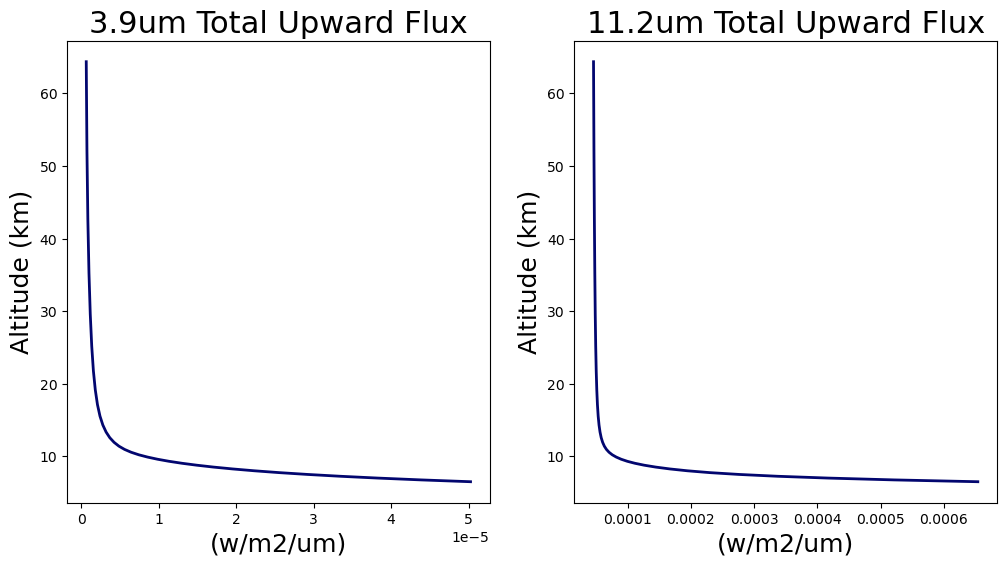

In [4]:
fig,ax=plt.subplots(1, 2, figsize=(12,6))
ax[0].set_ylabel("Altitude (km)", size=18)
ax[0].set_xlabel("(w/m2/um)", size=18)
ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set_title("3.9um Total Upward Flux", size=22)
ax[0].plot(UP_F_sw, Z_sw, c='#02066F', linewidth=2)

ax[1].set_ylabel("Altitude (km)", size=18)
ax[1].set_xlabel("(w/m2/um)", size=18)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title("11.2um Total Upward Flux", size=22)
ax[1].plot(UP_F_lw, Z_lw, c='#02066F', linewidth=2)

plt.savefig('total_upward_flux.png', dpi=200, bbox_inches='tight')
plt.show()

In [5]:
T_lw = UP_F_lw/np.sum(UP_F_lw)
T_sw = UP_F_sw/np.sum(UP_F_sw)

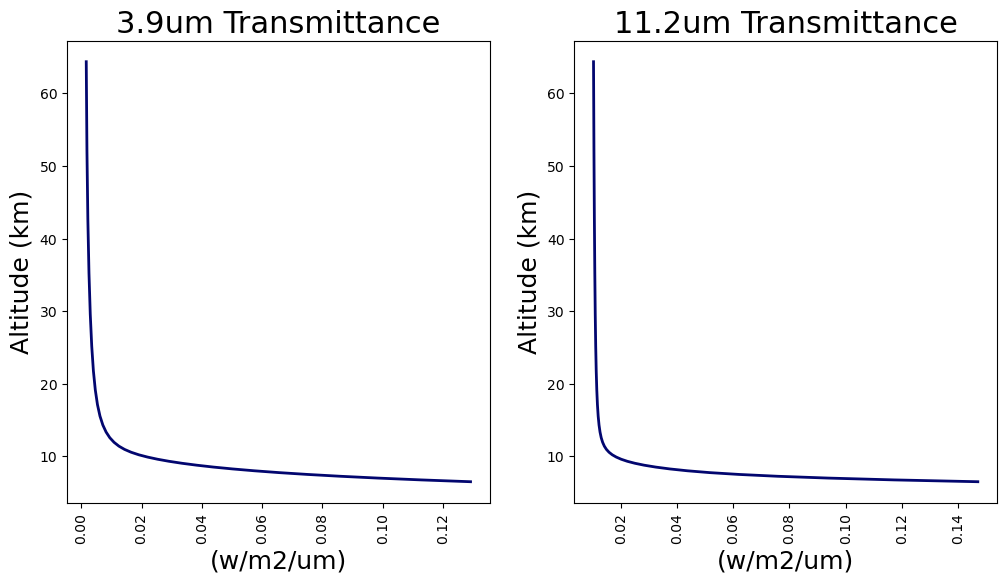

In [6]:
fig,ax=plt.subplots(1, 2, figsize=(12,6))
ax[0].set_ylabel("Altitude (km)", size=18)
ax[0].set_xlabel("(w/m2/um)", size=18)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title("3.9um Transmittance", size=22)
ax[0].plot(T_sw, Z_sw, c='#02066F', linewidth=2)

ax[1].set_ylabel("Altitude (km)", size=18)
ax[1].set_xlabel("(w/m2/um)", size=18)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title("11.2um Transmittance", size=22)
ax[1].plot(T_lw, Z_lw, c='#02066F', linewidth=2)

plt.show()

In [7]:
weight_sw = []
for i in range(len(Z_sw)-1):
    dz = Z_sw[i] - Z_sw[i+1]
    dT = T_sw[i] - T_sw[i+1]
    dT_dz = dT/dz
    weight_sw.append(-dT_dz)

weight_lw = []
for i in range(len(Z_lw)-1):
    dz = Z_lw[i] - Z_lw[i+1]
    dT = T_lw[i] - T_lw[i+1]
    dT_dz = dT/dz
    weight_lw.append(-dT_dz)

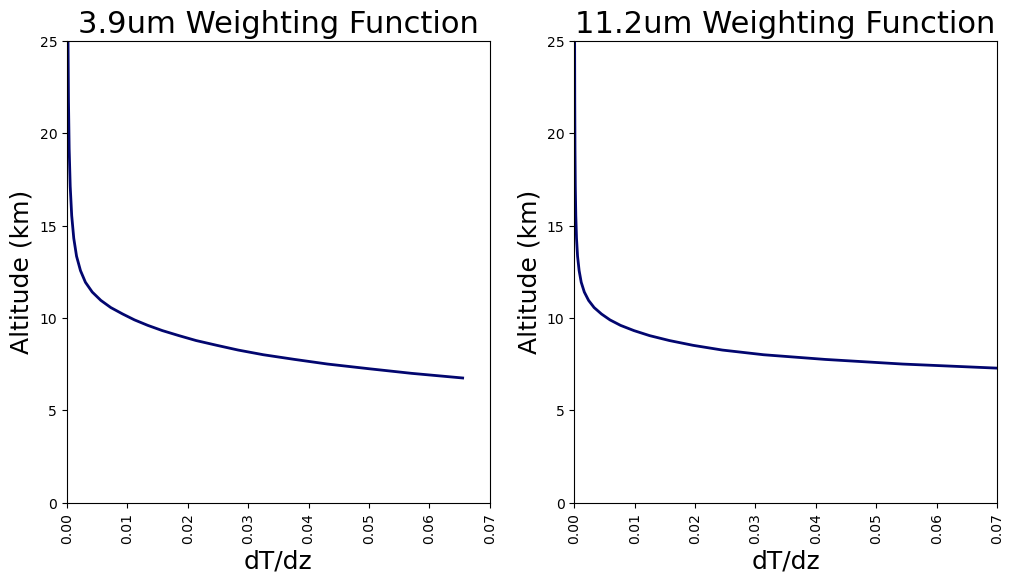

In [9]:
fig,ax=plt.subplots(1, 2, figsize=(12,6))
ax[0].set_ylabel("Altitude (km)", size=18)
ax[0].set_ylim(0, 25)
ax[0].set_xlabel("dT/dz", size=18)
ax[0].set_xlim(0, 0.07)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title("3.9um Weighting Function", size=22)
ax[0].plot(weight_sw, Z_sw[:-1], c='#02066F', linewidth=2)

ax[1].set_ylabel("Altitude (km)", size=18)
ax[1].set_ylim(0, 25)
ax[1].set_xlabel("dT/dz", size=18)
ax[1].set_xlim(0, 0.07)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title("11.2um Weighting Function", size=22)
ax[1].plot(weight_lw, Z_lw[:-1], c='#02066F', linewidth=2)

plt.savefig('weighting function.png', dpi=200, bbox_inches='tight')
plt.show()